# Using causal-ccm to infer causality in time series data

In 2012, Sugihara et al. formulated the [Convergent Cross Mapping (CCM)](https://science.sciencemag.org/content/338/6106/496) methodology for inferring causality between elements in a complex system using just time-series data (no model of the system needed). 

In this notebook, we show an example how to use `causal-ccm` package to apply CCM on time series data.

## Installation
`pip install causal-ccm`

## Test Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # for showing progress bar in for loops

In [2]:
## Helper plotting function
def make_plots(df, dt_name, val1_name, val2_name):
    # drop nulls
    df = df[[dt_name, val1_name, val2_name]].dropna()
    
    # smoothen
    date_smooth = np.linspace(df[dt_name].min(), df[dt_name].max(), 100) 
    spl = make_interp_spline(df[dt_name], df[val1_name], k=2)
    val1 = spl(date_smooth)
    spl = make_interp_spline(df[dt_name], df[val2_name], k=2)
    val2 = spl(date_smooth)    
    r, p = np.round(pearsonr(df[val1_name], df[val2_name]), 4)
    
    # plot
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_smooth, val1, )
    ax = df.plot(x=dt_name, y=val1_name, marker='', c='b', linestyle='', legend=False, ax=ax)
    ax.set_ylabel(val1_name)
    ax2 = ax.twinx()
    ax2.plot(date_smooth, val2, c='r')
    df.plot(x=dt_name, y=val2_name, marker='', c='r', linestyle='', legend=False, ax=ax2)
    ax2.set_ylabel(val2_name)    
    ax.figure.legend()        
    plt.title(f"{val1_name} and {val2_name}, correlation coefficient: {r}", size=16)
    plt.tight_layout()
    plt.show()

## Sample CCM Usage

### Generate Dataset

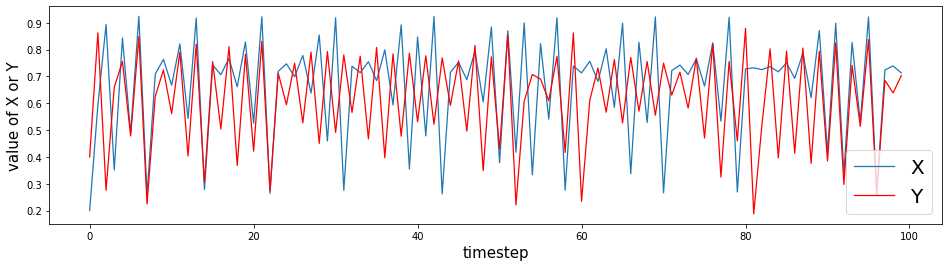

In [3]:
# Initialize test dataset

def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

# params
r_x = 3.7
r_y = 3.7
B_xy = 0 # effect on x given y (effect of y on x)
B_yx = 0.32 # effect on y given x (effect of x on y)

X0 = 0.2 # initial val following Sugihara et al
Y0 = 0.4 # initial val following Sugihara et al
t = 3000 # time steps

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)   
    
plt.figure(figsize=(16,4))
max_t = 100
plt.plot(X[:max_t], linewidth=1.25, label='X')
plt.plot(Y[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of X or Y', size=15)
plt.legend(prop={'size': 20})    

In [4]:
# !pip install causal-ccm

In [5]:
from causal_ccm.causal_ccm import ccm

/Users/prince.javier/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Checking X->Y

In [6]:
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(X) # length of time period to consider

ccm1 = ccm(X, Y, tau, E, L)

In [7]:
# causality X -> Y
# returns: (correlation ("strength" of causality), p-value(significance))
ccm1.causality()

(0.9922458514060817, 0.0)

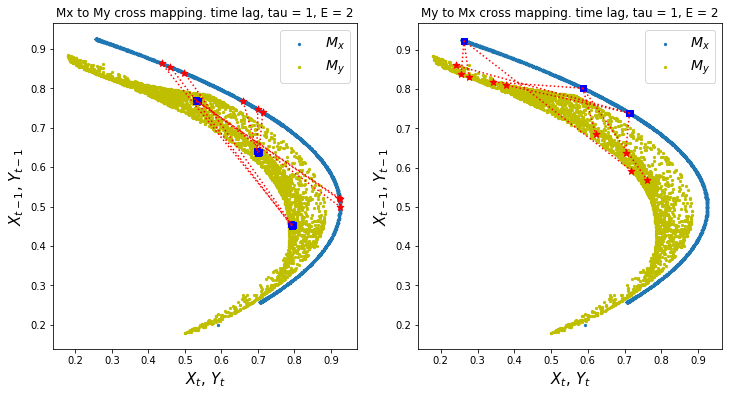

In [8]:
# visualize sample cross mapping
ccm1.visualize_cross_mapping()

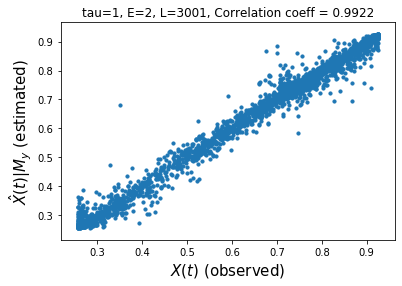

In [9]:
# Check correlation plot
ccm1.plot_ccm_correls() 

100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


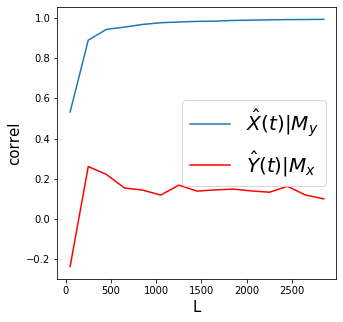

In [10]:
# checking convergence
# Looking at "convergence"
L_range = range(50, 3000, 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})    
    